# Interactive analysis

This notebook is used only for checking the properties of one simulation.

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Auxiliary functions

def plot_colloid(rawtrj):

    f, ax = plt.subplots(figsize=(5, 5));

    trj_particle = rawtrj[rawtrj.type==1]
    trj_trap = rawtrj[rawtrj.type==2]

    frame = 0
    xparticle = np.array(trj_particle.loc[idx[frame,:],"x"])
    yparticle = np.array(trj_particle.loc[idx[frame,:],"y"])
    ax.plot(xparticle,yparticle,'o', color='y')

    xtrap = np.array(trj_trap.loc[idx[frame,:],"x"])
    ytrap = np.array(trj_trap.loc[idx[frame,:],"y"])
    ax.plot(xtrap,ytrap,'o', color='g')

    ax.axis("square");
    return f,ax

def classify_vertices(vrt):
    vrt["type"] = np.NaN

    vrt.loc[vrt.eval("coordination==4 & charge == -4"),"type"] = 1
    vrt.loc[vrt.eval("coordination==4 & charge == -2"),"type"] = 2
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)==0"),"type"] = 3
    vrt.loc[vrt.eval("coordination==4 & charge == 0 & (dx**2+dy**2)>0"),"type"] = 4 # Dipolo
    vrt.loc[vrt.eval("coordination==4 & charge == 2"),"type"] = 5
    vrt.loc[vrt.eval("coordination==4 & charge == 4"),"type"] = 6
    return vrt

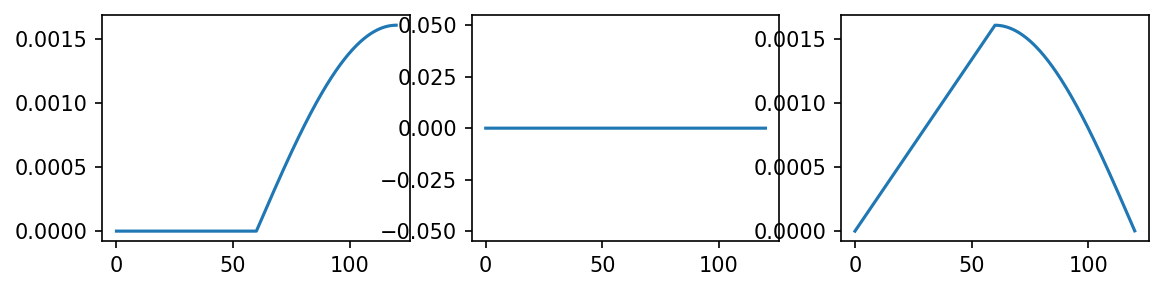

In [4]:
# Some parameters from the file
totalTime = 60*ureg.s
framespersec = 20*ureg.Hz
dt = 10*ureg.ms

# Importing files
trj_raw = trj = pd.read_csv("../data/ramp_and_rotation_20mT/trj/trj1.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/ramp_and_rotation_20mT/ctrj/ctrj1.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))


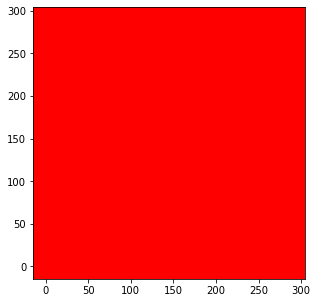

In [6]:
# Plotting the trajectories just to see everything is OK
f,ax = plot_colloid(trj_raw);
for i, trj_i in trj_raw.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(np.array(trj_i.x),np.array(trj_i.y), color = "r")

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

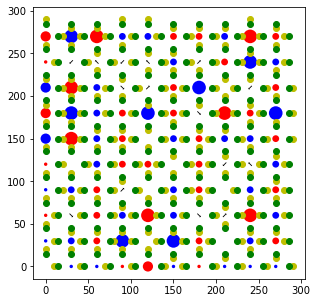

In [16]:
# Plotting the vertices charges
v = ice.vertices()

frame = 2399
v = v.trj_to_vertices(ctrj_raw.loc[frame])

f,ax = plot_colloid(trj_raw)
v.display(ax)

In [17]:
# OPTIONAL. RUN IF YOU DONT HAVE THE VERTICES  YET

v = ice.vertices()
frames = ctrj_raw.index.get_level_values("frame").unique()

v.trj_to_vertices(ctrj_raw.loc[frames[:]])
v.vertices.to_csv('../data/vertices.csv')

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: UnitStrippedWarning

Text(0, 0.5, 'fraction of vertices')

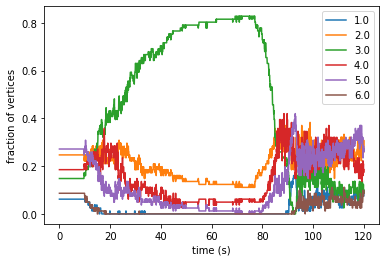

In [18]:
# OPTIONAL. RUN IF YOU HAVE THE VERTICES FILE
vertices = pd.read_csv("../data/vertices.csv", index_col=[0,1])
vertices = classify_vertices(vertices)
vertices = vertices.dropna()

count = ice.count_vertices(vertices)
for vertexType,v_t in count.groupby("type"):
    plotTime = np.array(v_t.index.get_level_values('frame')) / framespersec
    vertexFraction = np.array(v_t.fraction)
    plt.plot(plotTime, vertexFraction, label = vertexType)
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('fraction of vertices')